# SHAP Values Workshop

Welcome to the **SHAP Values Workshop**! During this session, we’ll explore how to interpret various machine learning model predictions using SHAP (SHapley Additive exPlanations).

## Workshop Overview

**Length**: 1.5 hours

1. **Introduction to SHAP Values (40 minutes)**
   - Overview of interpretability and its importance.
   - The theory behind Shapley values. (don't need to focus on this too much)
   - How SHAP extends Shapley values to machine learning.
   - Real world examples

2. **Break (10 minutes)**
   - We can use this time to ensure everyone's environment is setup correctly and pretrained models are loading, or just to stretch your legs.

3. **Hands-On SHAP Applications (40 minutes)**
   - Walkthrough with a simple multiple linear regression.
   - Walkthrough with a classifier.
   -  Walkthrough with a neural network (LSTM).

**We’ll use pretrained models (trained on the CAMELS dataset). You’ll load each model, run the SHAP package to generate explanations, and discuss how to interpret them.**


## 1. Applying SHAP to a Multiple Linear Regression

### 1.1 Dataset Overview
- Let's do some preliminary exploratory data analysis on the CAMELS dataset



In [1]:
# Set project directories
import os
# Back out one directory to project folder
PROJECT_DIR = os.path.dirname(os.path.abspath(''))
os.chdir(PROJECT_DIR)

# Set directories
DATA_DIR = os.path.join(PROJECT_DIR, 'data', 'processed')
FIGURE_DIR = os.path.join(PROJECT_DIR, 'outputs','figures')
OUTPUT_DIR = os.path.join(PROJECT_DIR, "outputs")
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
CONFIG_DIR = os.path.join(PROJECT_DIR, "config")

In [2]:
# Read in your data
import pandas as pd
df = pd.read_csv(os.path.join(DATA_DIR, 'CAMELS.csv'), index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

,STAID,Q,Dayl(s),PRCP(mm/day),SRAD(W/m2),SWE(mm),Tmax(C),Tmin(C),Vp(Pa),Annual Runoff (mm d-1),Annual Precip (mm d-1),Annual PET (mm d-1),Annual Temp (C),DA (km2),Elevation (m),Slope (m km-1),Frac Forest (%)
DATE,,,,,,,,,,,,,,,,,
1980-01-01,1013500,655.0,30172.48,0.0,218.66,0.0,-13.04,-13.04,203.28,1.66,2.781,1.95,3.931,2303.95,250.31,21.64152,0.9063
1980-01-02,1013500,640.0,30253.07,0.0,199.05,0.0,-10.93,-10.93,237.37,1.66,2.781,1.95,3.931,2303.95,250.31,21.64152,0.9063
1980-01-03,1013500,625.0,30344.16,0.0,197.64,0.0,-13.60,-13.60,169.39,1.66,2.781,1.95,3.931,2303.95,250.31,21.64152,0.9063
1980-01-04,1013500,620.0,30408.34,0.0,214.61,0.0,-16.53,-16.53,134.57,1.66,2.781,1.95,3.931,2303.95,250.31,21.64152,0.9063
1980-01-05,1013500,605.0,30413.49,0.0,206.02,0.0,-17.60,-17.60,129.30,1.66,2.781,1.95,3.931,2303.95,250.31,21.64152,0.9063


In [15]:
df.drop(columns=['STAID'], inplace=True)
print(df.isna().sum())

Q                         0
Dayl(s)                   0
PRCP(mm/day)              0
SRAD(W/m2)                0
SWE(mm)                   0
Tmax(C)                   0
Tmin(C)                   0
Vp(Pa)                    0
Annual Runoff (mm d-1)    0
Annual Precip (mm d-1)    0
Annual PET (mm d-1)       0
Annual Temp (C)           0
DA (km2)                  0
Elevation (m)             0
Slope (m km-1)            0
Frac Forest (%)           0
dtype: int64


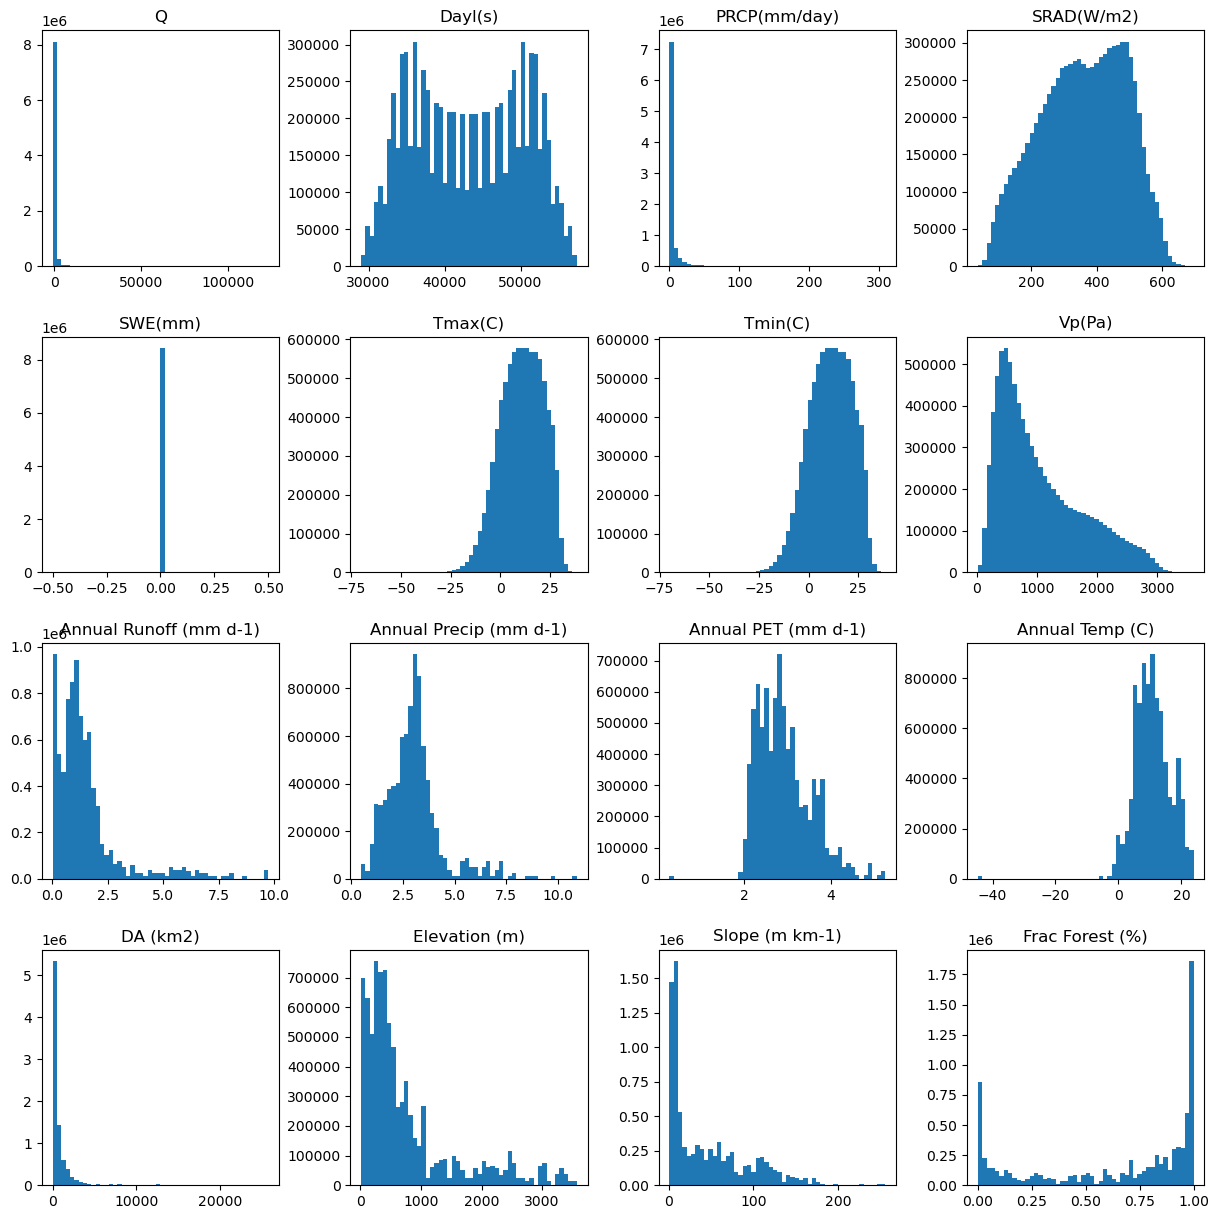

In [16]:
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(15, 15), grid=False)
plt.show()

### 1.2 Preprocess data 
- Split dataframe in X (inputs) and y (target) and scale input data from 0 - 1

In [17]:
from sklearn.preprocessing import MinMaxScaler
X = df.drop('Q', axis=1)
y = df['Q']

feat_scaler = MinMaxScaler()
X_sc = pd.DataFrame(
    feat_scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

y_scaler = MinMaxScaler()
y_sc = pd.Series(y_scaler.fit_transform(y.values.reshape(-1,1)).squeeze(),
    index=y.index, name='Q')

### 1.3 Loading the Pretrained Multiple Linear Regression
Use `np.load` to load pretrained multiple linear regression model


In [ ]:
# Load in pre-trained multiple linear regression model
import numpy as np
from sklearn.linear_model import LinearRegression

# Load in model from .npz file
w = np.load(os.path.join(MODEL_DIR, "linear_regression_weights.npz"), allow_pickle=True)

# Extract coefficients, intercepts, and feature names
linreg = LinearRegression()
linreg.coef_           = w["coef"]
linreg.intercept_      = w["intercept"][()]   
linreg.n_features_in_  = int(w["n_features_in"])

# Restore column labels
if w["feature_names_in"] is not None:
    linreg.feature_names_in_ = w["feature_names_in"]

15


### 1.3 Running SHAP Explanations
We'll use SHAP's `Explainer` for the **Multiple Linear Regression model**. Then we generate `shap_values` for the dataset.


In [ ]:
import shap
# Generate for 10% slice of time series starting at a random point
X_arr = np.array(X_sc)
y_arr = np.array(y_sc)
start = np.random.randint(0, X_sc.shape[0])
end = int(start + 0.1*len(X_sc))

# Store in arrays for future reference
X_shap = X_arr[start: end]
y_shap = y_arr[start: end]
feature_names = list(X.columns)

# Generate shap Explainer object and shap values
linear_explainer = shap.Explainer(linreg, X_shap)
shap_values = linear_explainer(X_shap)

Linear explainer:  66%|██████▌   | 5544626/8438500 [03:32<02:12, 21907.59it/s] 


### 1.4 Visualizing SHAP values
- The SHAP package has built in visualizations to help interpret SHAP values. **We can examine SHAP values globally or for local predictions.**
- In this workshop, we'll explore 3 visualization techniques:

    1. **Bar plot** (feature importance)

    2. **Beeswarm plot** (feature attribution)

    3. **Dependence plot** (How a single feature affects predictions)

    3. **Force Plot** (balance of forces for a given prediction) (just do locally)


#### 1.4.1 Bar Plots
- Bar plots are used to visualize overall feature importance based on their SHAP values, but doesn't contain any information on the directionality of the feature-prediction relationship.

In [ ]:
# A global feature importance bar plot
shap.bar_plot(shap_values, X_shap, feature_names=feature_names)

In [ ]:
# A local feature importance plot
shap.bar_plot(shap_values, X_shap[0: ], feature_names=feature_names)

#### 1.4.2 Beeswarm plots
- Beeswarm plots show not only feature importance, but feature directionality as well

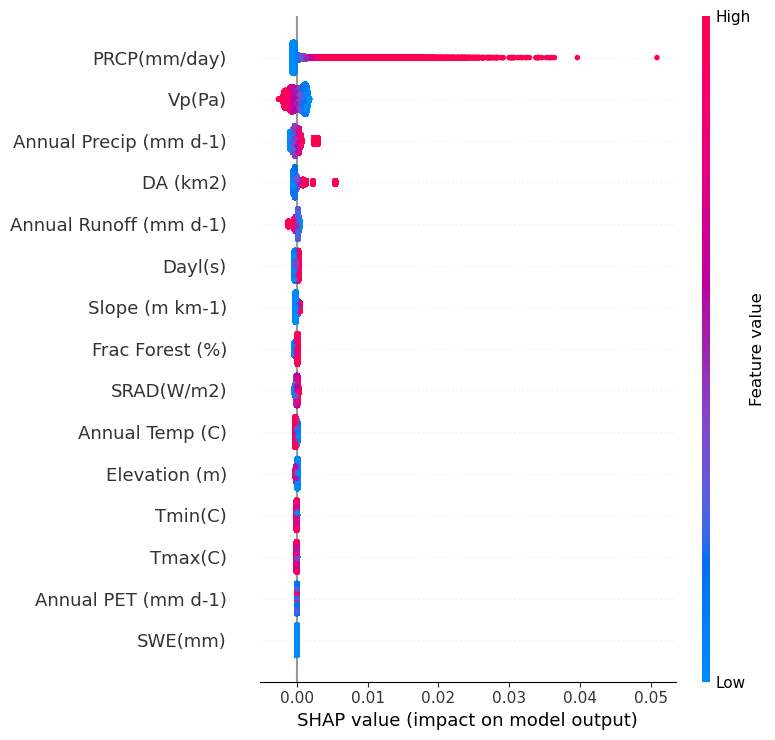

In [26]:
# A global feature importance plot
shap.summary_plot(shap_values, X_shap, feature_names=feature_names)

In [27]:
# A local feature importance plot
shap.summary_plot(shap_values, X_shap[0, :], feature_names=feature_names)

IndexError: tuple index out of range

#### Local Explanations
Use a force plot to explain a single observation in detail.


In [ ]:
# Example for local explanation:
# shap.plots.force(shap_values[0])  # explain the first sample

## 2. Neural Network (LSTM) with SHAP

- Now we'll demonstrate generating and interpreting SHAP values with a Neural Network (LSTM) model

## 3. Applying SHAP to a Classifier


### 3.1 Dataset Overview
- (Ryan fill in here)


## 6. Wrap-Up and Next Steps
- **Summary of Key Takeaways**:

## 7. Q&A and Resources
- **Q&A**: Ask questions about usage, best practices, or advanced features.
- **Resources**:
  - [SHAP GitHub repo](https://github.com/slundberg/shap)
  - [Official SHAP documentation and example notebooks](https://shap.readthedocs.io/en/latest/)
  - [Original SHAP paper (Lundberg & Lee, 2017)](https://arxiv.org/pdf/1705.07874)

Thank you for attending the **SHAP Values Workshop**!